## Train and Prediction on valid data

Using rotated to hz + OpenCv border

Basic default transforms

see:

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

and

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

mem use 3GB with bs=32 TODO increase

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [3]:
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from callbacks import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [4]:
__version__

'1.0.59.dev0'

In [5]:
m = EfficientNet.from_pretrained('efficientnet-b6')

Loaded pretrained weights for efficientnet-b6


In [6]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [7]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [8]:
arch_summary(lambda _: m)

(0) Conv2dStaticSamePadding: 2   layers (total: 2)
(1) BatchNorm2d : 1   layers (total: 3)
(2) ModuleList  : 711 layers (total: 714)
(3) Conv2dStaticSamePadding: 2   layers (total: 716)
(4) BatchNorm2d : 1   layers (total: 717)
(5) AdaptiveAvgPool2d: 1   layers (total: 718)
(6) Dropout     : 1   layers (total: 719)
(7) Linear      : 1   layers (total: 720)
(8) MemoryEfficientSwish: 1   layers (total: 721)


In [9]:
arch_summary(lambda _: list(m.children())[2])

(0) MBConvBlock : 13  layers (total: 13)
(1) MBConvBlock : 13  layers (total: 26)
(2) MBConvBlock : 13  layers (total: 39)
(3) MBConvBlock : 16  layers (total: 55)
(4) MBConvBlock : 16  layers (total: 71)
(5) MBConvBlock : 16  layers (total: 87)
(6) MBConvBlock : 16  layers (total: 103)
(7) MBConvBlock : 16  layers (total: 119)
(8) MBConvBlock : 16  layers (total: 135)
(9) MBConvBlock : 16  layers (total: 151)
(10) MBConvBlock : 16  layers (total: 167)
(11) MBConvBlock : 16  layers (total: 183)
(12) MBConvBlock : 16  layers (total: 199)
(13) MBConvBlock : 16  layers (total: 215)
(14) MBConvBlock : 16  layers (total: 231)
(15) MBConvBlock : 16  layers (total: 247)
(16) MBConvBlock : 16  layers (total: 263)
(17) MBConvBlock : 16  layers (total: 279)
(18) MBConvBlock : 16  layers (total: 295)
(19) MBConvBlock : 16  layers (total: 311)
(20) MBConvBlock : 16  layers (total: 327)
(21) MBConvBlock : 16  layers (total: 343)
(22) MBConvBlock : 16  layers (total: 359)
(23) MBConvBlock : 16  laye

In [10]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [11]:
data_dir_02 = Path('data_02')
data_dir = Path('data')

In [12]:
RETRAIN = True
RESIZE_IMAGES = True

In [13]:
MODEL_NAME='efficientnet'

In [14]:
NB_NUM='06_15'

In [15]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: a5302673, DATE: 20191128


In [16]:
#DATE = '20191118'
#UID = '701a968c'

In [17]:
SUB_NUM='24'

In [18]:
img_size=256
bs=32
border='reflect'
cutoff='blk_cutoff_25'

In [19]:
train_images=data_dir_02/f'train/rotated/clipped/{border}/{cutoff}/{img_size}'
#train image folder is same as test
test_images=data_dir_02/f'test/rotated/clipped/{border}/{cutoff}/{img_size}'

In [20]:
test_names = get_image_files(test_images)

In [21]:
#assert len(test_names)==7325

In [22]:
df_all=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [23]:
df_all.drop(columns=['target'],inplace=True)

In [24]:
df_valid=df_all.loc[df_all['verified'] == True]

### Note we are predicting the unverified images

In [25]:
df_test=df_all.loc[df_all['verified'] == False]

In [26]:
#df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [27]:
df_test.tail()

,country,id,region,roof_material,verified
22459,st_lucia,7a22ddec,gros_islet,healthy_metal,False
22460,st_lucia,7a2f73ea,gros_islet,healthy_metal,False
22461,st_lucia,7a34ffa4,gros_islet,healthy_metal,False
22462,st_lucia,7a41560a,gros_islet,healthy_metal,False
22463,st_lucia,7a283ad0,gros_islet,healthy_metal,False


In [28]:
xtra_tfms=[dihedral(p=0.05), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.25, max_warp=0., xtra_tfms=xtra_tfms)

### setup dataset

In [29]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [30]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [31]:
#to check what params object has
#dir(data)

In [32]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256

In [33]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

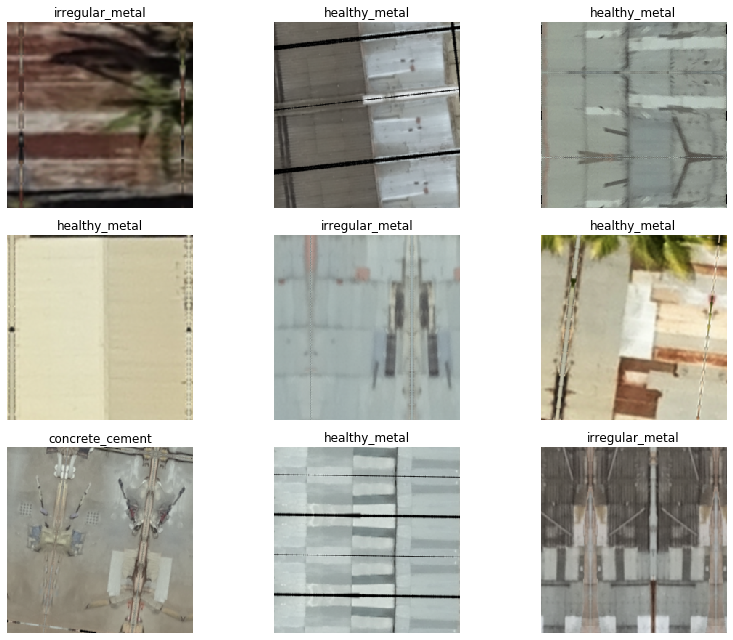

In [34]:
data.show_batch(rows=3, figsize=(12,9))

In [35]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

### Model

In [36]:
# "pretrained" is hardcoded to adapt to the PyTorch model function
def efficient_net_b6(pretrained=True):
    model = EfficientNet.from_pretrained('efficientnet-b6')
    return nn.Sequential(model)

In [37]:
model_meta[efficient_net_b6] =  { 'cut': noop, 
                               'split': lambda m: (list(m[0][0].children())[2][7], m[1]) }

In [38]:
list(efficient_net_b6()[0].children())

Loaded pretrained weights for efficientnet-b6


[Conv2dStaticSamePadding(
   3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ),
 BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 ModuleList(
   (0): MBConvBlock(
     (_depthwise_conv): Conv2dStaticSamePadding(
       56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
       (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
     )
     (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_se_reduce): Conv2dStaticSamePadding(
       56, 14, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_se_expand): Conv2dStaticSamePadding(
       14, 56, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_project_conv): Conv2dStaticSamePadding(
       56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
       (static_padding): Identi

In [39]:
output_size = list(efficient_net_b6()[0].children())[-2].out_features

Loaded pretrained weights for efficientnet-b6


In [40]:
output_size

1000

In [41]:
custom_head = nn.Linear(output_size, data.c)

In [42]:
arch = efficient_net_b6
arch_name = 'efficient_net_b6'

In [43]:
learn = cnn_learner(data, arch, custom_head = custom_head, metrics=error_rate, bn_final=True).to_fp16()

Loaded pretrained weights for efficientnet-b6


In [44]:
get_groups(nn.Sequential(*list(learn.model[0][0].children())[:2], 
                         *list(learn.model[0][0].children())[2],
                         *list(learn.model[0][0].children())[3:],
                         learn.model[1]), 
           learn.layer_groups)

Group 1: ['Conv2dStaticSamePadding', 'BatchNorm2d', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock']
Group 2: ['MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'Conv2dStaticSamePadding', 'BatchNorm2d', 'AdaptiveAvgPool2d', 'Dropout', 'Linear', 'MemoryEfficientSwish']
Group 3: ['Linear']


In [45]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [46]:
save_name=f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
callbacks = [SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=save_name, uid=UID)]

We use the LR Finder to pick a good learning rate.

### train model

In [47]:
learn.lr_find()

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0._blocks.32._expand_conv.weight", "0.0._blocks.32._bn0.weight", "0.0._blocks.32._bn0.bias", "0.0._blocks.32._bn0.running_mean", "0.0._blocks.32._bn0.running_var", "0.0._blocks.32._depthwise_conv.weight", "0.0._blocks.32._bn1.weight", "0.0._blocks.32._bn1.bias", "0.0._blocks.32._bn1.running_mean", "0.0._blocks.32._bn1.running_var", "0.0._blocks.32._se_reduce.weight", "0.0._blocks.32._se_reduce.bias", "0.0._blocks.32._se_expand.weight", "0.0._blocks.32._se_expand.bias", "0.0._blocks.32._project_conv.weight", "0.0._blocks.32._bn2.weight", "0.0._blocks.32._bn2.bias", "0.0._blocks.32._bn2.running_mean", "0.0._blocks.32._bn2.running_var", "0.0._blocks.33._expand_conv.weight", "0.0._blocks.33._bn0.weight", "0.0._blocks.33._bn0.bias", "0.0._blocks.33._bn0.running_mean", "0.0._blocks.33._bn0.running_var", "0.0._blocks.33._depthwise_conv.weight", "0.0._blocks.33._bn1.weight", "0.0._blocks.33._bn1.bias", "0.0._blocks.33._bn1.running_mean", "0.0._blocks.33._bn1.running_var", "0.0._blocks.33._se_reduce.weight", "0.0._blocks.33._se_reduce.bias", "0.0._blocks.33._se_expand.weight", "0.0._blocks.33._se_expand.bias", "0.0._blocks.33._project_conv.weight", "0.0._blocks.33._bn2.weight", "0.0._blocks.33._bn2.bias", "0.0._blocks.33._bn2.running_mean", "0.0._blocks.33._bn2.running_var", "0.0._blocks.34._expand_conv.weight", "0.0._blocks.34._bn0.weight", "0.0._blocks.34._bn0.bias", "0.0._blocks.34._bn0.running_mean", "0.0._blocks.34._bn0.running_var", "0.0._blocks.34._depthwise_conv.weight", "0.0._blocks.34._bn1.weight", "0.0._blocks.34._bn1.bias", "0.0._blocks.34._bn1.running_mean", "0.0._blocks.34._bn1.running_var", "0.0._blocks.34._se_reduce.weight", "0.0._blocks.34._se_reduce.bias", "0.0._blocks.34._se_expand.weight", "0.0._blocks.34._se_expand.bias", "0.0._blocks.34._project_conv.weight", "0.0._blocks.34._bn2.weight", "0.0._blocks.34._bn2.bias", "0.0._blocks.34._bn2.running_mean", "0.0._blocks.34._bn2.running_var", "0.0._blocks.35._expand_conv.weight", "0.0._blocks.35._bn0.weight", "0.0._blocks.35._bn0.bias", "0.0._blocks.35._bn0.running_mean", "0.0._blocks.35._bn0.running_var", "0.0._blocks.35._depthwise_conv.weight", "0.0._blocks.35._bn1.weight", "0.0._blocks.35._bn1.bias", "0.0._blocks.35._bn1.running_mean", "0.0._blocks.35._bn1.running_var", "0.0._blocks.35._se_reduce.weight", "0.0._blocks.35._se_reduce.bias", "0.0._blocks.35._se_expand.weight", "0.0._blocks.35._se_expand.bias", "0.0._blocks.35._project_conv.weight", "0.0._blocks.35._bn2.weight", "0.0._blocks.35._bn2.bias", "0.0._blocks.35._bn2.running_mean", "0.0._blocks.35._bn2.running_var", "0.0._blocks.36._expand_conv.weight", "0.0._blocks.36._bn0.weight", "0.0._blocks.36._bn0.bias", "0.0._blocks.36._bn0.running_mean", "0.0._blocks.36._bn0.running_var", "0.0._blocks.36._depthwise_conv.weight", "0.0._blocks.36._bn1.weight", "0.0._blocks.36._bn1.bias", "0.0._blocks.36._bn1.running_mean", "0.0._blocks.36._bn1.running_var", "0.0._blocks.36._se_reduce.weight", "0.0._blocks.36._se_reduce.bias", "0.0._blocks.36._se_expand.weight", "0.0._blocks.36._se_expand.bias", "0.0._blocks.36._project_conv.weight", "0.0._blocks.36._bn2.weight", "0.0._blocks.36._bn2.bias", "0.0._blocks.36._bn2.running_mean", "0.0._blocks.36._bn2.running_var", "0.0._blocks.37._expand_conv.weight", "0.0._blocks.37._bn0.weight", "0.0._blocks.37._bn0.bias", "0.0._blocks.37._bn0.running_mean", "0.0._blocks.37._bn0.running_var", "0.0._blocks.37._depthwise_conv.weight", "0.0._blocks.37._bn1.weight", "0.0._blocks.37._bn1.bias", "0.0._blocks.37._bn1.running_mean", "0.0._blocks.37._bn1.running_var", "0.0._blocks.37._se_reduce.weight", "0.0._blocks.37._se_reduce.bias", "0.0._blocks.37._se_expand.weight", "0.0._blocks.37._se_expand.bias", "0.0._blocks.37._project_conv.weight", "0.0._blocks.37._bn2.weight", "0.0._blocks.37._bn2.bias", "0.0._blocks.37._bn2.running_mean", "0.0._blocks.37._bn2.running_var", "0.0._blocks.38._expand_conv.weight", "0.0._blocks.38._bn0.weight", "0.0._blocks.38._bn0.bias", "0.0._blocks.38._bn0.running_mean", "0.0._blocks.38._bn0.running_var", "0.0._blocks.38._depthwise_conv.weight", "0.0._blocks.38._bn1.weight", "0.0._blocks.38._bn1.bias", "0.0._blocks.38._bn1.running_mean", "0.0._blocks.38._bn1.running_var", "0.0._blocks.38._se_reduce.weight", "0.0._blocks.38._se_reduce.bias", "0.0._blocks.38._se_expand.weight", "0.0._blocks.38._se_expand.bias", "0.0._blocks.38._project_conv.weight", "0.0._blocks.38._bn2.weight", "0.0._blocks.38._bn2.bias", "0.0._blocks.38._bn2.running_mean", "0.0._blocks.38._bn2.running_var", "0.0._blocks.39._expand_conv.weight", "0.0._blocks.39._bn0.weight", "0.0._blocks.39._bn0.bias", "0.0._blocks.39._bn0.running_mean", "0.0._blocks.39._bn0.running_var", "0.0._blocks.39._depthwise_conv.weight", "0.0._blocks.39._bn1.weight", "0.0._blocks.39._bn1.bias", "0.0._blocks.39._bn1.running_mean", "0.0._blocks.39._bn1.running_var", "0.0._blocks.39._se_reduce.weight", "0.0._blocks.39._se_reduce.bias", "0.0._blocks.39._se_expand.weight", "0.0._blocks.39._se_expand.bias", "0.0._blocks.39._project_conv.weight", "0.0._blocks.39._bn2.weight", "0.0._blocks.39._bn2.bias", "0.0._blocks.39._bn2.running_mean", "0.0._blocks.39._bn2.running_var", "0.0._blocks.40._expand_conv.weight", "0.0._blocks.40._bn0.weight", "0.0._blocks.40._bn0.bias", "0.0._blocks.40._bn0.running_mean", "0.0._blocks.40._bn0.running_var", "0.0._blocks.40._depthwise_conv.weight", "0.0._blocks.40._bn1.weight", "0.0._blocks.40._bn1.bias", "0.0._blocks.40._bn1.running_mean", "0.0._blocks.40._bn1.running_var", "0.0._blocks.40._se_reduce.weight", "0.0._blocks.40._se_reduce.bias", "0.0._blocks.40._se_expand.weight", "0.0._blocks.40._se_expand.bias", "0.0._blocks.40._project_conv.weight", "0.0._blocks.40._bn2.weight", "0.0._blocks.40._bn2.bias", "0.0._blocks.40._bn2.running_mean", "0.0._blocks.40._bn2.running_var", "0.0._blocks.41._expand_conv.weight", "0.0._blocks.41._bn0.weight", "0.0._blocks.41._bn0.bias", "0.0._blocks.41._bn0.running_mean", "0.0._blocks.41._bn0.running_var", "0.0._blocks.41._depthwise_conv.weight", "0.0._blocks.41._bn1.weight", "0.0._blocks.41._bn1.bias", "0.0._blocks.41._bn1.running_mean", "0.0._blocks.41._bn1.running_var", "0.0._blocks.41._se_reduce.weight", "0.0._blocks.41._se_reduce.bias", "0.0._blocks.41._se_expand.weight", "0.0._blocks.41._se_expand.bias", "0.0._blocks.41._project_conv.weight", "0.0._blocks.41._bn2.weight", "0.0._blocks.41._bn2.bias", "0.0._blocks.41._bn2.running_mean", "0.0._blocks.41._bn2.running_var", "0.0._blocks.42._expand_conv.weight", "0.0._blocks.42._bn0.weight", "0.0._blocks.42._bn0.bias", "0.0._blocks.42._bn0.running_mean", "0.0._blocks.42._bn0.running_var", "0.0._blocks.42._depthwise_conv.weight", "0.0._blocks.42._bn1.weight", "0.0._blocks.42._bn1.bias", "0.0._blocks.42._bn1.running_mean", "0.0._blocks.42._bn1.running_var", "0.0._blocks.42._se_reduce.weight", "0.0._blocks.42._se_reduce.bias", "0.0._blocks.42._se_expand.weight", "0.0._blocks.42._se_expand.bias", "0.0._blocks.42._project_conv.weight", "0.0._blocks.42._bn2.weight", "0.0._blocks.42._bn2.bias", "0.0._blocks.42._bn2.running_mean", "0.0._blocks.42._bn2.running_var", "0.0._blocks.43._expand_conv.weight", "0.0._blocks.43._bn0.weight", "0.0._blocks.43._bn0.bias", "0.0._blocks.43._bn0.running_mean", "0.0._blocks.43._bn0.running_var", "0.0._blocks.43._depthwise_conv.weight", "0.0._blocks.43._bn1.weight", "0.0._blocks.43._bn1.bias", "0.0._blocks.43._bn1.running_mean", "0.0._blocks.43._bn1.running_var", "0.0._blocks.43._se_reduce.weight", "0.0._blocks.43._se_reduce.bias", "0.0._blocks.43._se_expand.weight", "0.0._blocks.43._se_expand.bias", "0.0._blocks.43._project_conv.weight", "0.0._blocks.43._bn2.weight", "0.0._blocks.43._bn2.bias", "0.0._blocks.43._bn2.running_mean", "0.0._blocks.43._bn2.running_var", "0.0._blocks.44._expand_conv.weight", "0.0._blocks.44._bn0.weight", "0.0._blocks.44._bn0.bias", "0.0._blocks.44._bn0.running_mean", "0.0._blocks.44._bn0.running_var", "0.0._blocks.44._depthwise_conv.weight", "0.0._blocks.44._bn1.weight", "0.0._blocks.44._bn1.bias", "0.0._blocks.44._bn1.running_mean", "0.0._blocks.44._bn1.running_var", "0.0._blocks.44._se_reduce.weight", "0.0._blocks.44._se_reduce.bias", "0.0._blocks.44._se_expand.weight", "0.0._blocks.44._se_expand.bias", "0.0._blocks.44._project_conv.weight", "0.0._blocks.44._bn2.weight", "0.0._blocks.44._bn2.bias", "0.0._blocks.44._bn2.running_mean", "0.0._blocks.44._bn2.running_var". 
	Unexpected key(s) in state_dict: "0.0._blocks.2._expand_conv.weight", "0.0._blocks.2._bn0.weight", "0.0._blocks.2._bn0.bias", "0.0._blocks.2._bn0.running_mean", "0.0._blocks.2._bn0.running_var", "0.0._blocks.2._bn0.num_batches_tracked". 
	size mismatch for 0.0._conv_stem.weight: copying a param with shape torch.Size([48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([56, 3, 3, 3]).
	size mismatch for 0.0._bn0.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._bn0.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._bn0.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._bn0.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._depthwise_conv.weight: copying a param with shape torch.Size([48, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([56, 1, 3, 3]).
	size mismatch for 0.0._blocks.0._bn1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._bn1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._bn1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._bn1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._se_reduce.weight: copying a param with shape torch.Size([12, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([14, 56, 1, 1]).
	size mismatch for 0.0._blocks.0._se_reduce.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([14]).
	size mismatch for 0.0._blocks.0._se_expand.weight: copying a param with shape torch.Size([48, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([56, 14, 1, 1]).
	size mismatch for 0.0._blocks.0._se_expand.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for 0.0._blocks.0._project_conv.weight: copying a param with shape torch.Size([24, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 56, 1, 1]).
	size mismatch for 0.0._blocks.0._bn2.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.0._bn2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.0._bn2.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.0._bn2.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._depthwise_conv.weight: copying a param with shape torch.Size([24, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for 0.0._blocks.1._bn1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._se_reduce.weight: copying a param with shape torch.Size([6, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 32, 1, 1]).
	size mismatch for 0.0._blocks.1._se_reduce.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for 0.0._blocks.1._se_expand.weight: copying a param with shape torch.Size([24, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 8, 1, 1]).
	size mismatch for 0.0._blocks.1._se_expand.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._project_conv.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1, 1]).
	size mismatch for 0.0._blocks.1._bn2.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn2.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.1._bn2.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._depthwise_conv.weight: copying a param with shape torch.Size([144, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for 0.0._blocks.2._bn1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._bn1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._bn1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._bn1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._se_reduce.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 32, 1, 1]).
	size mismatch for 0.0._blocks.2._se_reduce.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for 0.0._blocks.2._se_expand.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 8, 1, 1]).
	size mismatch for 0.0._blocks.2._se_expand.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for 0.0._blocks.2._project_conv.weight: copying a param with shape torch.Size([32, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1, 1]).
	size mismatch for 0.0._blocks.3._project_conv.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 192, 1, 1]).
	size mismatch for 0.0._blocks.3._bn2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.3._bn2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.3._bn2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.3._bn2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.4._expand_conv.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.4._bn0.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn0.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn0.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._depthwise_conv.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for 0.0._blocks.4._bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._se_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.4._se_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.4._se_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.4._se_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.4._project_conv.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for 0.0._blocks.4._bn2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.4._bn2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.4._bn2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.4._bn2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.5._expand_conv.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.5._bn0.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn0.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn0.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._depthwise_conv.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for 0.0._blocks.5._bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._se_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.5._se_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.5._se_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.5._se_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.5._project_conv.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for 0.0._blocks.5._bn2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.5._bn2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.5._bn2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.5._bn2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.6._expand_conv.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.6._bn0.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn0.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn0.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._depthwise_conv.weight: copying a param with shape torch.Size([192, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for 0.0._blocks.6._bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._se_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.6._se_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.6._se_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.6._se_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.6._project_conv.weight: copying a param with shape torch.Size([56, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for 0.0._blocks.6._bn2.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.6._bn2.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.6._bn2.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.6._bn2.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.7._expand_conv.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.7._bn0.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn0.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn0.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn0.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._depthwise_conv.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for 0.0._blocks.7._bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._se_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.7._se_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.7._se_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.7._se_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.7._project_conv.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for 0.0._blocks.7._bn2.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.7._bn2.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.7._bn2.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.7._bn2.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.8._expand_conv.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.8._bn0.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn0.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn0.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn0.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._depthwise_conv.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for 0.0._blocks.8._bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._se_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.8._se_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.8._se_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.8._se_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.8._project_conv.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for 0.0._blocks.8._bn2.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.8._bn2.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.8._bn2.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.8._bn2.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for 0.0._blocks.9._expand_conv.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for 0.0._blocks.9._bn0.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn0.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn0.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn0.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._depthwise_conv.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 5, 5]).
	size mismatch for 0.0._blocks.9._bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._se_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for 0.0._blocks.9._se_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for 0.0._blocks.9._se_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for 0.0._blocks.9._se_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for 0.0._blocks.9._project_conv.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 240, 1, 1]).
	size mismatch for 0.0._blocks.9._bn2.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.9._bn2.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.9._bn2.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.9._bn2.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.10._expand_conv.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.10._bn0.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn0.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn0.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn0.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._depthwise_conv.weight: copying a param with shape torch.Size([336, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 5, 5]).
	size mismatch for 0.0._blocks.10._bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._se_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.10._se_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.10._se_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.10._se_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.10._project_conv.weight: copying a param with shape torch.Size([112, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 432, 1, 1]).
	size mismatch for 0.0._blocks.10._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.10._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.10._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.10._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.11._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.11._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 5, 5]).
	size mismatch for 0.0._blocks.11._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.11._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.11._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.11._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.11._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 432, 1, 1]).
	size mismatch for 0.0._blocks.11._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.11._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.11._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.11._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.12._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.12._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 5, 5]).
	size mismatch for 0.0._blocks.12._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.12._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.12._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.12._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.12._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 432, 1, 1]).
	size mismatch for 0.0._blocks.12._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.12._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.12._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.12._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.13._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.13._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 5, 5]).
	size mismatch for 0.0._blocks.13._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.13._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.13._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.13._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.13._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 432, 1, 1]).
	size mismatch for 0.0._blocks.13._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.13._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.13._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.13._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.14._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.14._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 5, 5]).
	size mismatch for 0.0._blocks.14._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.14._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.14._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.14._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.14._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([72, 432, 1, 1]).
	size mismatch for 0.0._blocks.14._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.14._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.14._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.14._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for 0.0._blocks.15._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 72, 1, 1]).
	size mismatch for 0.0._blocks.15._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([432, 1, 3, 3]).
	size mismatch for 0.0._blocks.15._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 432, 1, 1]).
	size mismatch for 0.0._blocks.15._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 0.0._blocks.15._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([432, 18, 1, 1]).
	size mismatch for 0.0._blocks.15._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for 0.0._blocks.15._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 432, 1, 1]).
	size mismatch for 0.0._blocks.15._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.15._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.15._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.15._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.16._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.16._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.16._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.16._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.16._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.16._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.16._project_conv.weight: copying a param with shape torch.Size([160, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.16._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.16._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.16._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.16._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.17._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.17._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.17._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.17._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.17._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.17._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.17._project_conv.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.17._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.17._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.17._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.17._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.18._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.18._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.18._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.18._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.18._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.18._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.18._project_conv.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.18._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.18._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.18._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.18._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.19._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.19._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.19._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.19._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.19._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.19._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.19._project_conv.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.19._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.19._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.19._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.19._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.20._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.20._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.20._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.20._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.20._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.20._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.20._project_conv.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.20._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.20._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.20._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.20._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.21._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.21._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.21._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.21._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.21._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.21._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.21._project_conv.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.21._bn2.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.21._bn2.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.21._bn2.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.21._bn2.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.22._expand_conv.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.22._bn0.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn0.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn0.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._depthwise_conv.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 3, 3]).
	size mismatch for 0.0._blocks.22._bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._se_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.22._se_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.22._se_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.22._se_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.22._project_conv.weight: copying a param with shape torch.Size([272, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 864, 1, 1]).
	size mismatch for 0.0._blocks.22._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.22._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.22._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.22._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for 0.0._blocks.23._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 144, 1, 1]).
	size mismatch for 0.0._blocks.23._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([864, 1, 5, 5]).
	size mismatch for 0.0._blocks.23._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 864, 1, 1]).
	size mismatch for 0.0._blocks.23._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for 0.0._blocks.23._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([864, 36, 1, 1]).
	size mismatch for 0.0._blocks.23._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([864]).
	size mismatch for 0.0._blocks.23._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 864, 1, 1]).
	size mismatch for 0.0._blocks.23._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.23._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.23._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.23._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.24._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.24._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.24._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.24._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.24._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.24._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.24._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.24._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.24._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.24._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.24._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.25._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.25._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.25._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.25._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.25._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.25._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.25._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.25._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.25._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.25._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.25._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.26._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.26._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.26._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.26._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.26._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.26._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.26._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.26._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.26._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.26._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.26._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.27._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.27._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.27._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.27._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.27._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.27._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.27._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.27._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.27._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.27._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.27._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.28._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.28._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.28._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.28._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.28._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.28._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.28._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.28._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.28._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.28._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.28._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.29._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.29._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.29._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.29._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.29._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.29._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.29._project_conv.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.29._bn2.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.29._bn2.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.29._bn2.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.29._bn2.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.30._expand_conv.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.30._bn0.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn0.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn0.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn0.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._depthwise_conv.weight: copying a param with shape torch.Size([1632, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.30._bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._se_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.30._se_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.30._se_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.30._se_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.30._project_conv.weight: copying a param with shape torch.Size([448, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([200, 1200, 1, 1]).
	size mismatch for 0.0._blocks.30._bn2.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.30._bn2.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.30._bn2.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.30._bn2.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for 0.0._blocks.31._expand_conv.weight: copying a param with shape torch.Size([2688, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 200, 1, 1]).
	size mismatch for 0.0._blocks.31._bn0.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn0.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn0.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn0.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._depthwise_conv.weight: copying a param with shape torch.Size([2688, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1200, 1, 5, 5]).
	size mismatch for 0.0._blocks.31._bn1.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn1.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn1.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._bn1.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._se_reduce.weight: copying a param with shape torch.Size([112, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1200, 1, 1]).
	size mismatch for 0.0._blocks.31._se_reduce.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.0._blocks.31._se_expand.weight: copying a param with shape torch.Size([2688, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([1200, 50, 1, 1]).
	size mismatch for 0.0._blocks.31._se_expand.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1200]).
	size mismatch for 0.0._blocks.31._project_conv.weight: copying a param with shape torch.Size([448, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([344, 1200, 1, 1]).
	size mismatch for 0.0._blocks.31._bn2.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([344]).
	size mismatch for 0.0._blocks.31._bn2.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([344]).
	size mismatch for 0.0._blocks.31._bn2.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([344]).
	size mismatch for 0.0._blocks.31._bn2.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([344]).
	size mismatch for 0.0._conv_head.weight: copying a param with shape torch.Size([1792, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([2304, 576, 1, 1]).
	size mismatch for 0.0._bn1.weight: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for 0.0._bn1.bias: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for 0.0._bn1.running_mean: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for 0.0._bn1.running_var: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for 0.0._fc.weight: copying a param with shape torch.Size([1000, 1792]) from checkpoint, the shape in current model is torch.Size([1000, 2304]).

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(15, slice(lr), callbacks=callbacks)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [ ]:
learn.unfreeze()

In [ ]:
#learn.lr_find()
#learn.recorder.plot()

In [ ]:

learn.fit_one_cycle(5, slice(1e-5, lr/5), callbacks=callbacks)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.load(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn = learn.to_fp32()

In [ ]:
learn.export(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

### inference

In [ ]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [ ]:
len(test_dataset)

In [ ]:
learn = load_learner(path=train_images,file=f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [ ]:
learn.data.loss_func

In [ ]:
type(learn.data)

In [ ]:
type(learn.dl(DatasetType.Test))

In [ ]:
len(learn.dl(DatasetType.Test))

In [ ]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
labels = np.argmax(preds, 1)

In [ ]:
len(preds)

In [ ]:
preds[0].tolist()

In [ ]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [ ]:
len(labels)

In [ ]:
learn.data.classes

In [ ]:
data.classes

In [ ]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [ ]:
test_predictions[0]

In [ ]:
type(learn.data.test_ds)

In [ ]:
 learn.data.test_ds.x.items

In [ ]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [ ]:
preds_list[0]

In [ ]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [ ]:
cols

In [ ]:
df.head()

In [ ]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [ ]:
pred_df.insert(loc=0, column='id', value=ids)

In [ ]:
pred_df.columns = cols

In [ ]:
pred_df.head()

In [ ]:
pred_ids=pred_df['id'].values.tolist()

In [ ]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [ ]:
df_baseline.head()

In [ ]:
baseline_ids=df_baseline['id'].values.tolist()

In [ ]:
baseline_ids

In [ ]:
len(set(baseline_ids))

In [ ]:
len(set(pred_ids))

In [ ]:
pred_df = pred_df[~pred_df.id.str.contains('_')]

In [ ]:
pred_ids=pred_df['id'].values.tolist()

In [ ]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [ ]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [ ]:
pred_df.head()

In [ ]:
pred_df=pred_df.sort_values('id_cat')

In [ ]:
pred_df.head()

In [ ]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [ ]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [ ]:
## now just get the unverified preds
pred_df = pred_df.loc[df['is'].isin(df_test.id.values.tolist())]

In [ ]:
pred_df.to_csv(data_dir/f'processing/best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4461
